In [1]:
import random as rng

import imageio
import matplotlib.pyplot as plt
import numpy as np

from skimage import exposure
from skimage import filters
import cv2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from backend.signal_processing import (
    graphing,
    signal_transform,
    sigpro_utility,
)


/mnt/shared/code/damp_lab/beholder/.venv/lib/python3.8/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (227553.1 ms) doesn't match the set interval (300000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)
/mnt/shared/code/damp_lab/beholder/.venv/lib/python3.8/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (299769.0 ms) doesn't match the set interval (300000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


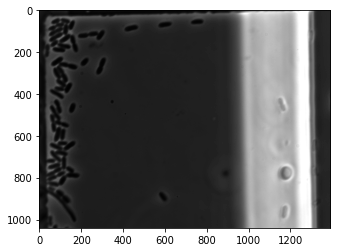

In [3]:
# Grab the initial greyscale frame.
input_path = '../../data/raw_nd2/New_SR_1_5_MC_TS10h.nd2'
input_frame = sigpro_utility.get_initial_image_nd2(input_path)
graphing.plot_notebook(input_frame)

/mnt/shared/code/damp_lab/beholder/.venv/lib/python3.8/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (227553.1 ms) doesn't match the set interval (300000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)
/mnt/shared/code/damp_lab/beholder/.venv/lib/python3.8/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (299769.0 ms) doesn't match the set interval (300000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


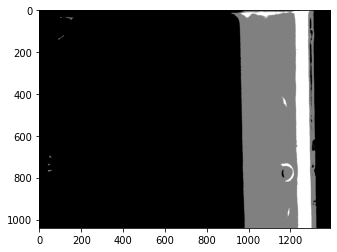

0
1
med_signal=7752
background_signal=3685.0
downshift_delta=7752.0
2
med_signal=13672
background_signal=3685.0
downshift_delta=13672.0


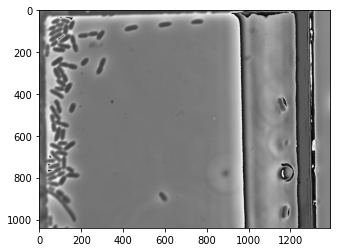

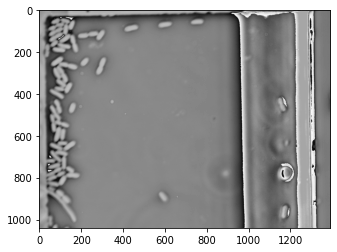

In [50]:
# So, let's try otsus again.
# The idea at the moment would be: determine center or features to steadycam the image around -> threshold the lips to
# ensure a sort of static frame.
input_frame_1 = sigpro_utility.get_initial_image_nd2(input_path)
# graphing.plot_histogram_notebook(input_frame_1)
# graphing.plot_notebook(input_frame_1)
# Determine the median value for all the binarized zeroth bin
out_array = filters.threshold_multiotsu(input_frame_1)
regions = np.digitize(input_frame_1, bins=out_array)
baseline_mask = ~np.array(regions, dtype=bool)
background_signal = np.median(input_frame_1[baseline_mask])
graphing.plot_notebook(regions)
out_array = np.insert(out_array, 0, 0)
for i in range(len(out_array)):
    print(i)
    if not i:
        continue
    med_signal = out_array[i]
    downshift_delta = abs(med_signal-background_signal)+background_signal
    print(f'{med_signal=}')
    print(f'{background_signal=}')
    print(f'{downshift_delta=}')
    for j in range(input_frame_1.shape[0]):
        for k in range(input_frame_1.shape[1]):
            if regions[j][k] == i:
                input_frame_1[j][k] = input_frame[j][k] - downshift_delta
graphing.plot_notebook(input_frame_1)
graphing.plot_notebook(cv2.bitwise_not(input_frame_1))
# Inefficent Solution
# thing = np.where(~regions, out_array, -1)
# for i in range(input_frame_1.shape[0]):
#     for j in range(input_frame_1.shape[1]):
#         print(f'{}')
#         regions[i][j] = out_array[regions[i][j]-1]
# print(f'{out_array=}')
# How do we use an np array as a boolean value.
# print(f'{np.unique(regions)=}')
# sub_array = input_frame_1 - regions
# graphing.plot_notebook(thing)

In [4]:
@interact(
    p1_x=widgets.IntSlider(min=0, max=input_frame.shape[1], value=input_frame.shape[0]/2),
    p1_y=widgets.IntSlider(min=0, max=input_frame.shape[0], value=input_frame.shape[1]/2),
    p2_x=widgets.IntSlider(min=0, max=input_frame.shape[1], value=input_frame.shape[0]/2),
    p2_y=widgets.IntSlider(min=0, max=input_frame.shape[0], value=input_frame.shape[1]/2),
)
def mask_selection(p1_x, p1_y, p2_x, p2_y):
    input_frame = sigpro_utility.get_initial_image_nd2(input_path)
    out_frame = cv2.circle(input_frame, (p1_x, p1_y), 20, 200, 3)
    out_frame = cv2.circle(out_frame, (p2_x, p2_y), 20, 100, 1)
    out_frame = cv2.rectangle(
                out_frame,
                (p1_x, p1_y),
                (p2_x, p2_y),
                255,
                5)
    graphing.plot_notebook(out_frame)

interactive(children=(IntSlider(value=520, description='p1_x', max=1392), IntSlider(value=696, description='p1…

In [5]:
@interact(
    p1_x=widgets.IntSlider(min=0, max=input_frame.shape[1], value=input_frame.shape[0]/2),
    p1_y=widgets.IntSlider(min=0, max=input_frame.shape[0], value=input_frame.shape[1]/2),
    p2_x=widgets.IntSlider(min=0, max=input_frame.shape[1], value=input_frame.shape[0]/2),
    p2_y=widgets.IntSlider(min=0, max=input_frame.shape[0], value=input_frame.shape[1]/2),
)
def swatch_selection(p1_x, p1_y, p2_x, p2_y):
    input_frame = sigpro_utility.get_initial_image_nd2(input_path)
    out_frame = cv2.circle(input_frame, (p1_x, p1_y), 20, 200, 3)
    out_frame = cv2.circle(out_frame, (p2_x, p2_y), 20, 100, 1)
    out_frame = cv2.rectangle(
                out_frame,
                (p1_x, p1_y),
                (p2_x, p2_y),
                255,
                5)
    graphing.plot_notebook(out_frame)


interactive(children=(IntSlider(value=520, description='p1_x', max=1392), IntSlider(value=696, description='p1…

In [6]:
def ghetto_submatrix_application(
        input_frame,
        point_one,
        point_two,
        value,
):
    x_0, x_1 = point_one[1], point_two[1]
    y_0, y_1 = point_one[0], point_two[0]
    for j in range(y_0, y_1):
        for i in range(x_0, x_1):
            input_frame[i][j] = input_frame[i][j] - value
    return input_frame

/mnt/shared/code/damp_lab/beholder/.venv/lib/python3.8/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (227553.1 ms) doesn't match the set interval (300000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)
/mnt/shared/code/damp_lab/beholder/.venv/lib/python3.8/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (299769.0 ms) doesn't match the set interval (300000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


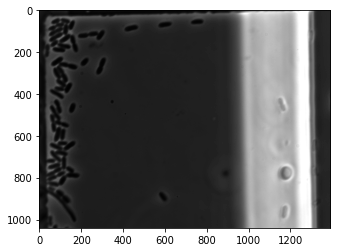

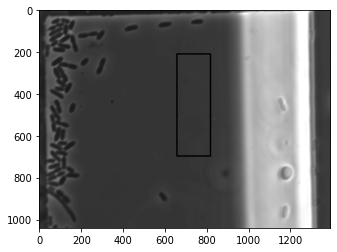

3592.0
3653.0


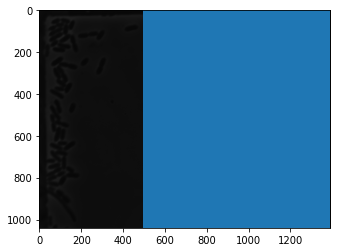

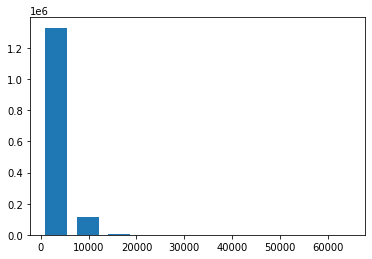

In [10]:
input_frame = sigpro_utility.get_initial_image_nd2(input_path)
graphing.plot_histogram_notebook(input_frame)
graphing.plot_notebook(input_frame)
swatch_point_1 = (657, 209)
swatch_point_2 = (817, 696)

mask_point_1 = (967, 0)
mask_point_2 = (1288, 1039)
out_frame = cv2.rectangle(
            input_frame,
            swatch_point_1,
            swatch_point_2,
            255,
            5)
graphing.plot_notebook(out_frame)
graphing.plot_histogram_notebook(out_frame)
calc_swatch_median = np.median(input_frame[
    swatch_point_1[0]:swatch_point_2[0],
    swatch_point_1[1]:swatch_point_2[1],
])
calc_mask_median = np.median(input_frame[
    mask_point_1[0]:mask_point_2[0],
    mask_point_1[1]:mask_point_2[1],
])
drop_value = abs(calc_swatch_median + calc_mask_median)
print(calc_swatch_median)
print(calc_mask_median)
normalized_frame = ghetto_submatrix_application(input_frame, mask_point_1, mask_point_2, drop_value)
graphing.plot_notebook(normalized_frame)
graphing.plot_histogram_notebook(normalized_frame)